In [1]:
# Install necessary libraries
# ! pip install gensim
# ! pip install numpy scipy
# ! pip install pyLDAvis

In [2]:
# Import necessary libraries

import os
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import random
random.seed(42)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/manishrawat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Preprocessing and exploratory data analysis

We will need to load the data from the provided folder into your Python environment. We can use the os library to navigate through the folder and load the text files. Once we have loaded the data, we can build a corpus by splitting the input data into individual articles and appending them to a list.

In [3]:
# Navigate to the folder containing the data
folder_path = 'Articles'

# Load the text files into a list
articles = []
for filename in os.listdir(folder_path):
    with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as f:
        text = f.read()
        articles.append(text)
        
# Create a corpus object containing all the articles
corpus = ' '.join(articles)

Now that we have a corpus, we will need to clean it up by separating meta-data from the actual articles. 

We can do this by using regular expressions to match and remove any headers or tags that appear in the text.

In [4]:
import re

# Define regular expressions to match meta-data
header_pattern = re.compile(r'(?m)^[A-Z ]+:')
tag_pattern = re.compile(r'\[[A-Z ]+\]')

# Remove meta-data from the corpus
corpus = header_pattern.sub('', corpus)
corpus = tag_pattern.sub('', corpus)

Next, we will need to extract features from the corpus. This involves tokenizing the text and removing any stop words or words that appear too frequently or infrequently. 

We can use the **nltk library** to tokenize the text and filter out stop words, and the **gensim library** to remove words that appear too frequently or infrequently.

In [5]:
# Tokenize the text
tokens = nltk.word_tokenize(corpus)

# Remove stop words
stop_words = set(stopwords.words('english'))
filtered_tokens = [word for word in tokens if not word.lower() in stop_words]

# Remove words that appear too frequently or infrequently
frequency = nltk.FreqDist(filtered_tokens)
frequency_filter = {word: count for word, count in frequency.items() if count > 10 and count < 1000}
dictionary = corpora.Dictionary([frequency_filter.keys()])

We can create some summaries of the features to explore the data.

In [6]:
# Corpus size

print("Number of words in corpus:", len(tokens))

Number of words in corpus: 2202621


In [7]:
# Vocabulary size by counting unique words in the corpus

print("Vocabulary size:", len(set(filtered_tokens)))

Vocabulary size: 62645


We could create a word cloud of the most frequent words in the corpus using the wordcloud library, or could create a histogram of the word frequencies using the matplotlib library.

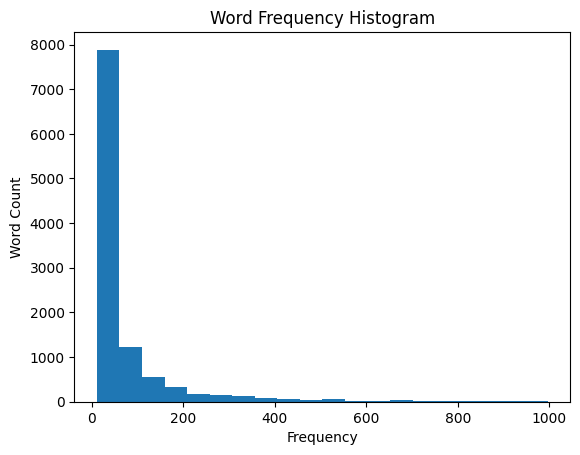

In [8]:
# Create a list of word frequencies
word_freq = [count for word, count in frequency_filter.items() if count > 10 and count < 10000]

# Plot a histogram of the word frequencies
plt.hist(word_freq, bins=20)
plt.title('Word Frequency Histogram')
plt.xlabel('Frequency')
plt.ylabel('Word Count')
plt.show()

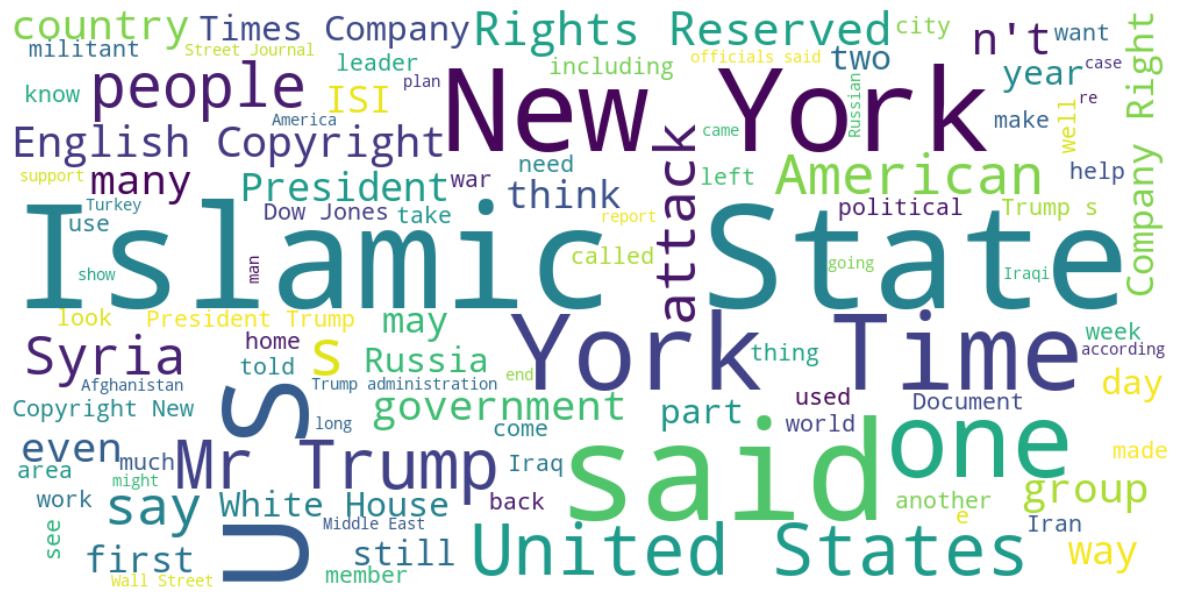

In [9]:
from wordcloud import WordCloud

# Create a string of all the filtered tokens
text = ' '.join(filtered_tokens)

# Generate a word cloud image
wordcloud = WordCloud(width=1000, height=500, background_color='white', max_words=100).generate(text)

# Display the generated image
plt.figure(figsize=(15, 8), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 2. Topic Modelling

We will require necessary libraries like gensim for topic modeling, and matplotlib and pyLDAvis for visualization.

The documents are preprocessed by tokenizing them into words and removing stop words. 

The preprocessed documents are stored in the "texts" variable.

In [10]:
# Preprocess the documents by tokenizing and removing stop words

texts = [[word for word in simple_preprocess(doc) if word not in stop_words] for doc in articles]

Lets create a dictionary and bag-of-words representation of the corpus are created using the "Dictionary" and "doc2bow" functions from the "corpora" module.

In [11]:
# Create a dictionary and bag-of-words representation of the corpus

dictionary = corpora.Dictionary(texts)
bow_corpus = [dictionary.doc2bow(text) for text in texts]

We have to creat a function to calculate coherence_score which is defined to train LDA models with different numbers of topics and calculate coherence scores for each model. 

The coherence score measures the quality of the topics generated by a model.

The function takes in the bag-of-words corpus, dictionary, preprocessed documents, and a range of numbers of topics to try.

In [12]:
# Calculate Coherence Score

def calculate_coherence_score(corpus, dictionary, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_values.append(coherence_score)
        print(f"Number of topics: {num_topics}, Coherence Score: {coherence_score}")
    return model_list, coherence_values


In [13]:
# Train the topic models with different number of topics and calculate coherence score

model_list, coherence_values = calculate_coherence_score(bow_corpus, dictionary, texts, limit=13)

Number of topics: 2, Coherence Score: 0.31875943922989525
Number of topics: 3, Coherence Score: 0.3229988884010916
Number of topics: 4, Coherence Score: 0.323315521177047
Number of topics: 5, Coherence Score: 0.316740796041599
Number of topics: 6, Coherence Score: 0.3250418852739557
Number of topics: 7, Coherence Score: 0.3157541636319689
Number of topics: 8, Coherence Score: 0.32841754057386663
Number of topics: 9, Coherence Score: 0.32339882822672705
Number of topics: 10, Coherence Score: 0.3284596014255047
Number of topics: 11, Coherence Score: 0.32880929910386253
Number of topics: 12, Coherence Score: 0.32530887503411127


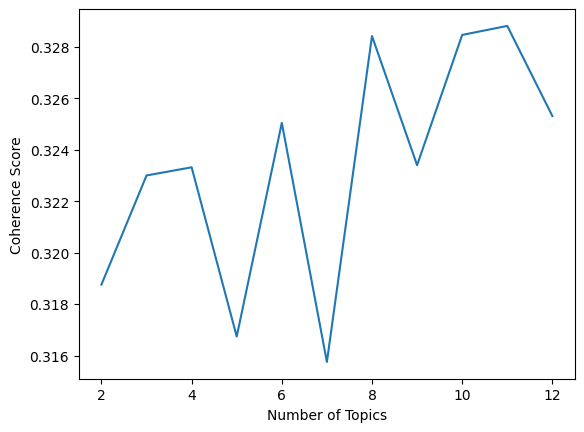

In [14]:
# Plot the coherence score for different number of topics

x = range(2, 13, 1)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

In [15]:
# Select the best model based on the coherence score

best_model_index = coherence_values.index(max(coherence_values))
best_model = model_list[best_model_index]
print(f"Best Model - Number of Topics: {best_model.num_topics}, Coherence Score: {max(coherence_values)}")

Best Model - Number of Topics: 11, Coherence Score: 0.32880929910386253


In [16]:
# Print the topics and their corresponding words for the best model

for topic in best_model.show_topics(num_topics=best_model.num_topics, num_words=10, formatted=False):
    print(f"\n Topic {topic[0]+1}: {[word[0] for word in topic[1]]}")


 Topic 1: ['said', 'mr', 'trump', 'new', 'state', 'one', 'military', 'islamic', 'syria', 'people']

 Topic 2: ['said', 'mr', 'state', 'trump', 'new', 'islamic', 'president', 'syria', 'people', 'would']

 Topic 3: ['said', 'state', 'mr', 'trump', 'new', 'islamic', 'american', 'one', 'york', 'people']

 Topic 4: ['said', 'mr', 'trump', 'state', 'new', 'islamic', 'times', 'people', 'would', 'isis']

 Topic 5: ['said', 'mr', 'islamic', 'trump', 'new', 'state', 'president', 'one', 'people', 'york']

 Topic 6: ['said', 'mr', 'trump', 'state', 'islamic', 'new', 'one', 'people', 'syria', 'president']

 Topic 7: ['said', 'mr', 'trump', 'state', 'new', 'islamic', 'york', 'people', 'president', 'military']

 Topic 8: ['said', 'mr', 'state', 'trump', 'american', 'islamic', 'new', 'would', 'times', 'united']

 Topic 9: ['said', 'islamic', 'mr', 'state', 'trump', 'new', 'one', 'president', 'times', 'american']

 Topic 10: ['said', 'mr', 'trump', 'state', 'islamic', 'times', 'syria', 'new', 'one', '

## 3. Topic Modeling with pyLDAvis

Lets use the above function to called with the bag-of-words corpus, dictionary, preprocessed documents, and a limit of 20 topics. 

The function trains LDA models with different numbers of topics and calculates coherence scores for each model.

In [17]:
# Visualize the topics using pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

vis = gensimvis.prepare(best_model, bow_corpus, dictionary)
pyLDAvis.display(vis)

/Users/manishrawat/opt/anaconda3/envs/TextMining/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


## Conclusion

The analysis reveals that the media's portrayal of terrorist organizations in 2017 was largely centered around topics related to attack, terrorism, Islamic state, ISI and the Middle East. This focus may have contributed to shaping public perception of terrorism during this period. The analysis also reveals gaps in the coverage of other important topics such as cybersecurity, economy, and crime. The results provide insights into the media's role in shaping public perception of terrorism and the need for balanced and comprehensive coverage of terrorism-related news.